# Preprocessing in Python

In [128]:
## Import Packages

import pandas as pd
import numpy as np
import pickle
import sys
sys.path.insert(0 , './../MAIN/')
from utils import *
import preprocess_functions
import networkx as nx

In [137]:
## Specify Variables

modality = 'CNV'
target = 'paper_BRCA_Subtype_PAM50'
pipeline = 'LogReg'
#pipeline = 'DESeq'

In [138]:
## Load Data

with open(f'./../../data/TCGA/BRCA/raw/{modality}_preprocessed.pkl' , 'rb') as file : 
    loaded_data = pickle.load(file)
    
count_mtx = loaded_data['datExpr']
datMeta = loaded_data['datMeta'].reset_index()[['patient' , target]].set_index('patient')

In [139]:
## Perform Feature Selection Pipeline

data_to_save = {}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

### Check if the index of the count matrix and the metadata match
if len(set(count_mtx.index) & set(datMeta.index)) == 0 : 
    count_mtx = count_mtx.T

### Perform Feature Selection for the specified pipeline
if pipeline == 'DESeq' :
    print('Performing Differential Gene Expression for Feature Selection')
    datMeta.index.name = 'index'

    count_mtx , datMeta = preprocess_functions.data_preprocess(count_mtx.astype(int).astype(np.float32), datMeta[target]  , gene_exp = True)

    ### Perform DESeq
    dds, vsd, top_genes = preprocess_functions.DESEQ(count_mtx , datMeta , target , n_genes=500)

    ### Save the data
    data_to_save[f'extracted_feats'] = list(set(top_genes))
    datExpr = pd.DataFrame(data=vsd , index=count_mtx.index , columns=count_mtx.columns)
    
elif pipeline == 'LogReg' : 
    print('Performing Logistic Regression for Feature Selection')
    
    ### Preprocess the data
    n_genes = count_mtx.shape[1]
    datExpr = count_mtx.loc[: , (count_mtx != 0).any(axis=0)] # remove any genes with all 0 expression
    
    extracted_feats , model = preprocess_functions.elastic_net(datExpr , datMeta[target] , l1_ratio = 1 , lam=0.01 , num_epochs=3000)
    
    ### Save the data
    data_to_save['extracted_feats'] = list(set(extracted_feats))
    data_to_save['model'] = {'model' : model}
    
    datMeta.index.name = 'index'
    datMeta = datMeta[target]
    
data_to_save['datExpr'] = datExpr
data_to_save['datMeta'] = datMeta

with open(f'./../../data/TCGA/BRCA/raw/{modality}_processed.pkl' , 'wb') as file : 
    pickle.dump(data_to_save , file)
    

Performing Logistic Regression for Feature Selection


Loss : 18.7461: 100%|██████████| 3000/3000 [00:05<00:00, 575.40epoch/s]


Model score : 0.612


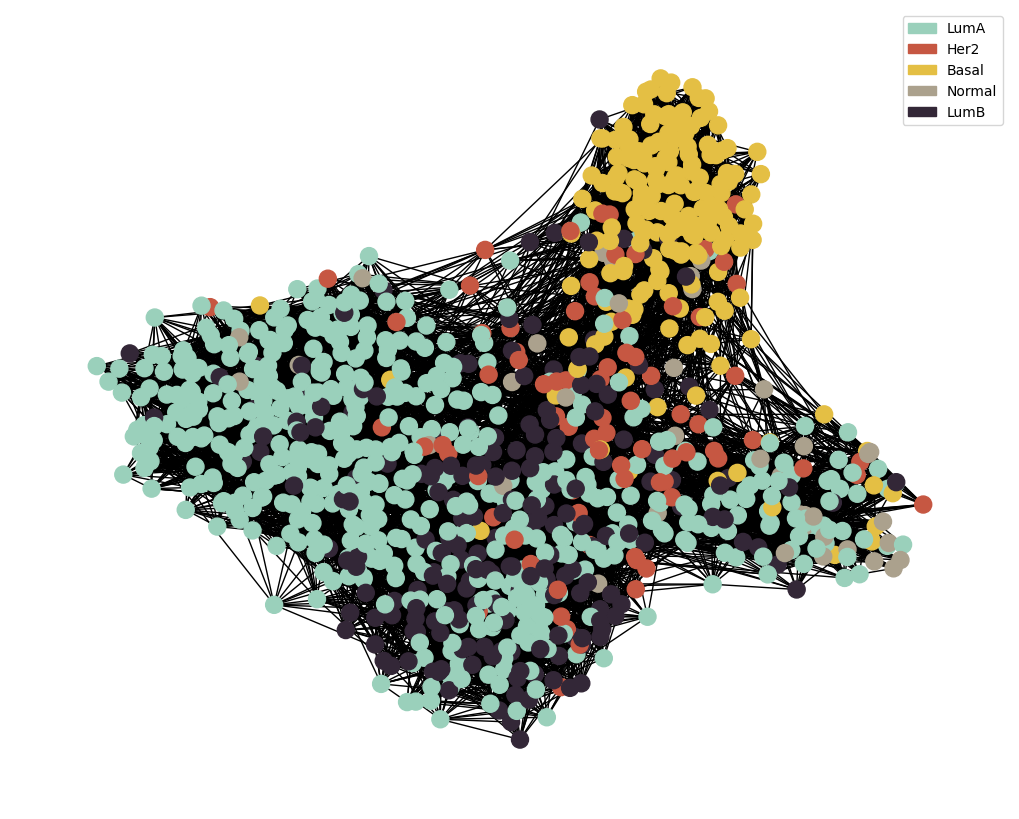

In [140]:
knn = 15
method = 'bicorr'
if len(data_to_save['extracted_feats']) > 0 : 
    G  = preprocess_functions.knn_graph_generation(datExpr , datMeta , method=method , 
                                                extracted_feats=data_to_save['extracted_feats'], node_size =150 , knn = knn )
else : 
    G  = preprocess_functions.knn_graph_generation(datExpr , datMeta , target , method=method , 
                                    extracted_feats=None, node_size =150 , knn = 15 )
    
nx.write_graphml(G, f'./../../data/TCGA/BRCA/Networks/{modality}_graph.graphml')